In [1]:
from funman import Funman
from funman.model import Parameter
from funman.parameter_space import ParameterSpace
from funman.scenario.parameter_synthesis import ParameterSynthesisScenario, ParameterSynthesisScenarioResult
from funman.utils.search_utils import ResultCombinedHandler, SearchConfig

from funman_demo.handlers import NotebookImageRefresher, RealtimeResultPlotter, ResultCacheWriter
from funman_demo.plot import plot_parameter_space, plot_cached_search

#%matplotlib inline

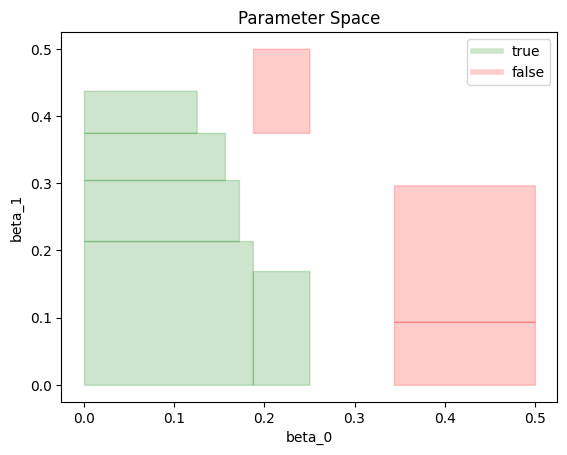

In [2]:
# The Funman module synthesizes the Parameter Space for a model, which encodes
# feasible parameter settings (denoted "true"), and infeasible parameter
# settings (denoted "false").  The code in this cell generates the Parameter
# Space and plots it.
#
# Funman synthesizes parameters with a box search algorithm that encodes a
# series of related Satisfiability Modulo Theories (SMT) encodings.  The box
# search involves sub-dividing the space of possible parameter-value
# combinations to identify boxes that either contain only feasible values or
# infeasible values for the parameters.  If a box contains a feasible point, the
# solver attempts to prove the absence of infeasible points.  If no infeasible
# points are found, then the box is labeled feasible.  Similarly, if a box
# contains an infeasible point and no feasible points, it is labeled infeasible.
# If a box contains both a feasible and infeasible point, then the solver
# subdivides the box.  The labeling and subdividing process continues until no
# boxes above a given threshold size remain.
#
# Funman evaluates the extracted model to identify values for beta that:
#  - Represent the intervention efficacy over two successive interventions
#  - Occur over two time periods 0-20 days (beta_1), and 20-30 days (beta_2)
#  - Prevent the number of infected I from exceeding 10% of the population
#  - Use a linearized definition for the S and R state update equations
#  - Fall within a specified range [0.0, 0.5]
#
# The Parameter Synthesis problem accepts two constants: 
#  - population_size: the number of individuals (S+I+R)
#  - infectious_days: the number of infected days before recovery
#
#  The scenario configuration also supports use of:
#  - epochs: the day index ranges corresponding to each beta
#  - read_cache_parameter_space: use a precomputed Parameter Space encoded as JSON
#  - write_cache_parameter_space: write a precomputed Parameter Space encoded as JSON
#  - real_time_plotting: whether to render the solver's progress
parameters = [Parameter("beta_0", lb=0.0, ub=0.5), Parameter("beta_1", lb=0.0, ub=0.5)]
gromet_file1 = "bar"

result1 : ParameterSynthesisScenarioResult = Funman().solve(
    ParameterSynthesisScenario(
        parameters, 
        gromet_file1,
        config = {
            "linearize": True,
            "epochs": [(0, 20), (20, 30)],
            "population_size": 1002,
            "infectious_days": 14.0,
        }),
        SearchConfig(
            tolerance=0.1,
            wait_action = NotebookImageRefresher("result1.png"),
            handler = ResultCombinedHandler([
                ResultCacheWriter("result1_cache.json"),
                RealtimeResultPlotter(
                    parameters,
                    plot_points=True,
                    realtime_save_path="result1.png"
                )
            ])
        ))

plot_parameter_space(result1.parameter_space, clear = True)

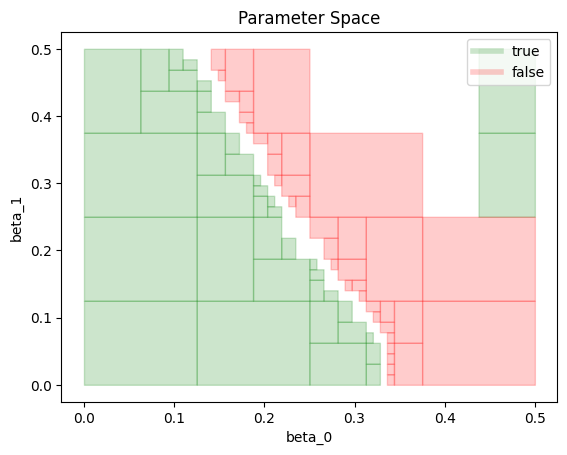

In [4]:
plot_cached_search("result1.json")

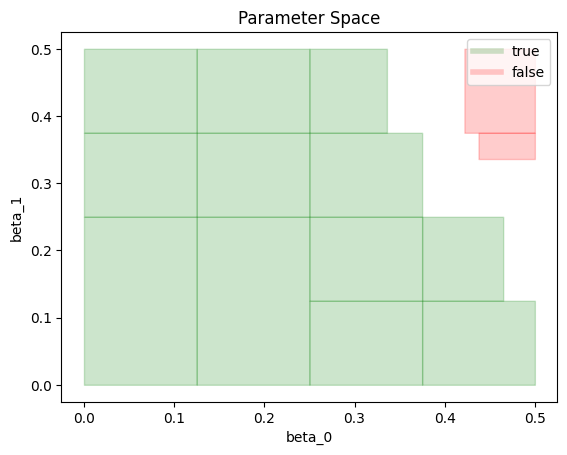

In [4]:
# This second use of Funman evaluates the model after changing the population
# size (10x) and infectious days (0.5x) constants.

parameters = [Parameter("beta_0", lb=0.0, ub=0.5), Parameter("beta_1", lb=0.0, ub=0.5)]
gromet_file2 = "baz"
result2 : ParameterSynthesisScenarioResult = Funman().solve(
    ParameterSynthesisScenario(
        parameters, 
        gromet_file2,
        config = {
            "linearize": True,
            "epochs": [(0, 20), (20, 30)],
            "population_size": 10020,
            "infectious_days": 7.0,
        }),
        SearchConfig(
            wait_action = NotebookImageRefresher("result2.png"),
            handler = ResultCombinedHandler([
                ResultCacheWriter("result2_cache.json"),
                RealtimeResultPlotter(
                    parameters,
                    plot_points=True,
                    realtime_save_path="result2.png"
                )
            ])
        ))

plot_parameter_space(result2.parameter_space, clear = True)

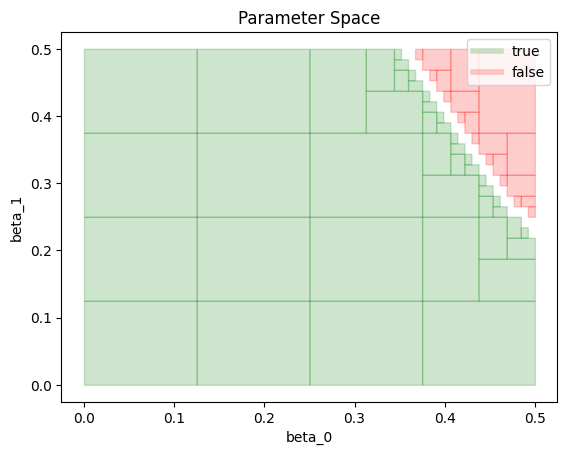

In [3]:
plot_cached_search("result2.json")

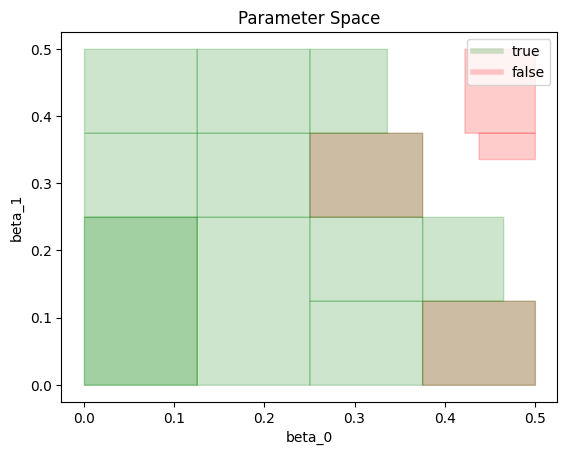

In [6]:
# Funman produces two parameter spaces for beta_0 and beta_1.  The parameter
# spaces overlap (i.e., have a non-empty intersection) and indicate values for
# the betas that are robust to changes in the model constants.  Similarly, the
# distinct regions (i.e., symmetric difference) denote parameter values where
# the models behave differently.
#
# The plot below illustrates:
# - The parameter space for the original model constants.
# - The parameter space for the modified model constants.
#
# The interpretation of the intersection (dark green, dark red) is that the feasible values for beta
# denote interventions that scale with population size and the number of
# infectious days.  These values warrant further investigation by the analyst.
# The interpretation of the symmetric difference is that the feasible values for
# beta denote interventions that will not scale with population size and the
# number of infectious days.  These values may be discarded by the analyst.

plot_parameter_space(result1.parameter_space)
plot_parameter_space(result2.parameter_space)